<a href="https://colab.research.google.com/github/Shreeeeeeeeeeeee/CTRW_2state/blob/main/CTRW_2step_Cuda_test(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
from numba import cuda, float32
import matplotlib.pyplot as plt
from math import sqrt
from math import copysign
import time as tpack
#!pip uninstall numba numba-cuda
#!pip install numba==0.61


Found existing installation: numba 0.61.0
Uninstalling numba-0.61.0:
  Would remove:
    /usr/local/bin/numba
    /usr/local/lib/python3.11/dist-packages/numba-0.61.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numba/*
Proceed (Y/n)? n
Found existing installation: numba-cuda 0.4.0
Uninstalling numba-cuda-0.4.0:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.pth
    /usr/local/lib/python3.11/dist-packages/_numba_cuda_redirector.py
    /usr/local/lib/python3.11/dist-packages/numba_cuda-0.4.0.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numba_cuda/*
Proceed (Y/n)? n


In [17]:
!uv pip install -q --system numba-cuda==0.4.0
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [18]:
!nvidia-smi

Mon Jul 21 08:26:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             28W /   70W |     498MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
import sys

def sizeof_fmt(num, suffix='B'):
    """Convert a size in bytes to a more readable format."""
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Y', suffix)

def get_variable_sizes(min_size_mb=1):
    """Get the size of all variables in the global scope and print them."""
    min_size_bytes = min_size_mb * 1024 * 1024
    variables = {}
    total_size = 0

    for name, obj in globals().items():
        if not name.startswith('_') and not callable(obj) and not isinstance(obj, type(sys)):
            size = sys.getsizeof(obj)
            total_size += size
            if size >= min_size_bytes:
                variables[name] = size

    # Sort variables by size
    sorted_vars = sorted(variables.items(), key=lambda item: item[1], reverse=True)

    # Print the variable sizes
    print(f"{'Variable':<20}{'Size':>15}")
    print("-" * 35)
    for name, size in sorted_vars:
        print(f"{name:<20}{sizeof_fmt(size):>15}")

    # Print the total size
    print("\nTotal size of all variables: ", sizeof_fmt(total_size))

#### Define a function that can write two numpy arrays or one column and other two-dimensional matrix

In [20]:
#writes a two column file taking two numpy arrays
def write_to_file(x,y,fname):
    if (x.ndim > 1):
        print ("Can write only one dimensional x-axis array, The dimension of x-array is ", x.ndim)
    elif(y.ndim > 2):
        print ("Can write only two dimensional y-axis array, The dimension of y-array is ", y.ndim)
    elif (y.ndim == 2 and x.shape[0] ==  y.shape[1]):
        f = open(fname,'w')
        for i in range(x.shape[0]):
            ystr = ''
            for k in range(y.shape[0]):
                ystr = ystr+'\t'+str(y[k,i])
            f.write(str(x[i])+ystr+'\n')
        f.close()
    elif (y.ndim == 1 and  x.shape[0] ==  y.shape[0]):
        f = open(fname,'w')
        for i in range(x.shape[0]):
            f.write(str(x[i])+'\t'+str(y[i])+'\n')
        f.close()
    else:
        print ("The arrays have incompatible number of rows with ", x.shape[0], " and ", y.shape[1])
    return

#### Define a function that can read a file and write numpy arrays

In [21]:
#read a n column file and returns two numpy arrays
def read_file(fname):
    f = open(fname,'r')
    lines = f.readlines()
    #check the number of columns
    ncol = len(lines[0].split())
    nrow = len(lines)
    f.close()

    if (ncol < 1):
        print ("The file has less than one column, something wrong!!")
        return [0],[0]

    elif (ncol == 1):
        x = np.zeros((nrow),dtype='float')
        for i in range(nrow):
            x[i] = float(lines[i].split()[0])
        return x

    elif (ncol == 2):

        x = np.zeros((nrow),dtype='float')
        y = np.zeros((nrow),dtype='float')
        for i in range(nrow):
            x[i] = float(lines[i].split()[0])
            y[i] = float(lines[i].split()[1])
        return x,y

    else :
        x = np.zeros((nrow),dtype='float')
        y = np.zeros((ncol-1,nrow),dtype='float')
        for i in range(nrow):
            x[i] = float( lines[i].split()[0] )
            for k in range(1,ncol):
                y[k-1,i] = float( lines[i].split()[k] )
        return x,y


### Defining autocorrelation using FCA algorithm (which uses FFT)

In [22]:
#Autocorrelation using FFT, theory shown in the above cell, with the case of S_{AB}
def autocorrFFT(x):
    N=len(x)
    F = np.fft.fft(x, n=2*N)  #2*N because of zero-padding
    PSD = F * F.conjugate()
    res = np.fft.ifft(PSD)
    res= (res[:N]).real   #now we have the autocorrelation in convention B
    n=N*np.ones(N)-np.arange(0,N) #divide res(m) by (N-m)
    return res/n #this is the autocorrelation in convention A

### Defining a function to calculate MSD using FCA (defined above)

In [23]:
#program to calculate the MSD
#number of timesteps
#A function to calculate the MSD from a trajectory,
#r - the trajectory is a numpy array : (n_tsteps,3)
#The function returns a numpy array with the shape : (n_tsteps)
def calc_msd(r,fft=True):
    if (fft): #cacluation of MSD using FFT
        N=len(r)
        D=np.square(r).sum(axis=1)
        D=np.append(D,0)
        S2=sum([autocorrFFT(r[:, i]) for i in range(r.shape[1])])
        Q=2*D.sum()
        S1=np.zeros(N)
        for m in range(N):
            Q=Q-D[m-1]-D[N-m]
            S1[m]=Q/(N-m)
        return S1-2*S2

    else: #calculation using the direct scheme
        N_tsteps =  r.shape[0]
        i,j,k = 0,0,0
        #f_t = IntProgress(min=0, max=N_tsteps,bar_style='success',description=fds2) # instantiate the timesteps bar
        i,j,k = 0,0,0
        #display(f_t) # display the molecules bar
        msd = np.zeros((r.shape),dtype='float64')
        msd_final = np.zeros((N_tsteps),dtype='float64')
        for j in range(0,N_tsteps-1):
            for k in range(0,N_tsteps-j):
                msd[j,:] = msd[j,:] + (r[k+j,:]-r[k,:])**2
            msd[j,:] = msd[j,:]/float(N_tsteps-j)
            msd_final[j] = np.sum(msd[j,:])
            #f_t.value += 1

        return msd_final

In [24]:
@cuda.jit
def ctrw_kernel(trand, xrand, trand2, xrand2, Xdist, x1, y1, x2, y2, Nt, Nens):
    """
    CUDA kernel for simulating 2D Continuous Time Random Walk (CTRW) with a cage-jump diffusion mechanism.

    This function executes in parallel across multiple CUDA threads to simulate trajectories for each ensemble member.

    Parameters:
    - trand (ndarray): Waiting times for caged diffusion.
    - xrand (ndarray): Jump lengths for caged diffusion.
    - trand2 (ndarray): Waiting times for jump diffusion.
    - xrand2 (ndarray): Jump lengths for jump diffusion.
    - Xdist (ndarray): Cage size distribution for each trajectory.
    - x1, y1 (ndarray): Position arrays for caged diffusion.
    - x2, y2 (ndarray): Position arrays for jump diffusion.
    - Nt (int): Number of time steps.
    - Nens (int): Number of ensemble trajectories.
    """
    k = cuda.grid(1)  # Get thread index
    if k >= Nens:
        return

    stop = 0
    i = 0

    # Simulating the caged diffusion process
    while stop < Nt:
        start = stop
        stop += int(trand[i, k, 0])  # Update stop time with waiting time

        # Compute radius and norm of random jump
        r1 = sqrt(x1[start - 1, k]**2 + y1[start - 1, k]**2) if start > 0 else 0.0
        rr = sqrt(xrand[i,k,0]**2 + xrand[i,k,1]**2) #np.linalg.norm(xrand[i, k])

        for t in range(start, min(stop, Nt)):
            x1[t, k] = x1[start - 1, k] \
                               + (1-int(abs((r1+rr)/(Xdist[k]))))* xrand[i,k,0] \
                               - int(abs((r1+rr)/(Xdist[k])))* \
                               copysign(1,x1[start-1,k]/xrand[i,k,0])* xrand[i,k,0]


            y1[t, k] = y1[start - 1, k] \
                                 + (1-int(abs((r1+rr)/(Xdist[k]))))* xrand[i,k,1] \
                                - int(abs((r1+rr)/(Xdist[k])))* \
                                 copysign(1,y1[start-1,k]/xrand[i,k,1])* xrand[i,k,1]

        i += 1

    stop = 1
    i = 0

    # Simulating the jump diffusion process
    while stop < Nt:
        start = stop
        stop += int(trand2[i, k, 0])  # Update stop time with waiting time

        for t in range(start, min(stop, Nt)):
            x2[t, k] = x2[start - 1, k] + xrand2[i, k, 0]
            y2[t, k] = y2[start - 1, k] + xrand2[i, k, 1]

        i += 1

def ctrw_ens2d_cuda(sig, tau, sig2, tau2, X0, Nens, Nt=1000, dt=1.0):
    """
    Generate 2D Continuous Time Random Walk (CTRW) trajectories using CUDA acceleration.

    This function simulates a combination of caged diffusion and jump diffusion using GPU parallelism.

    Parameters:
    - sig (float): Standard deviation of caged diffusion jump lengths.
    - tau (float): Mean waiting time for caged diffusion.
    - sig2 (float): Standard deviation of jump diffusion jump lengths.
    - tau2 (float): Mean waiting time for jump diffusion.
    - X0 (float): Mean cage size.
    - Nens (int): Number of trajectories.
    - Nt (int, optional): Number of time steps (default: 1000).
    - dt (float, optional): Time step size (default: 1.0).

    Returns:
    - T (ndarray): Array of time points.
    - x (ndarray): X-coordinates of the trajectories.
    - y (ndarray): Y-coordinates of the trajectories.
    """
    T = np.arange(0, Nt) * dt  # Time array

    # Generate waiting times and jump lengths for both diffusion types
    trand = np.random.exponential(tau, (2 * Nt, Nens, 1)).astype(np.float32)
    xrand = np.random.normal(0.0, sig, (2 * Nt, Nens, 2)).astype(np.float32)

    Xdist = np.random.exponential(X0, (Nens)).astype(np.float32)
    Xdist = np.clip(Xdist, 2 * sig, 12 * sig)  # Clip cage sizes to prevent extreme values

    trand2 = np.random.exponential(tau2, (2 * Nt, Nens, 1)).astype(np.float32)
    xrand2 = np.random.normal(0.0, sig2, (2 * Nt, Nens, 2)).astype(np.float32)

    # Initialize trajectory arrays
    x1 = np.zeros((Nt, Nens), dtype=np.float32)
    y1 = np.zeros((Nt, Nens), dtype=np.float32)
    x2 = np.zeros((Nt, Nens), dtype=np.float32)
    y2 = np.zeros((Nt, Nens), dtype=np.float32)

    # Move data to GPU
    d_trand = cuda.to_device(trand)
    d_xrand = cuda.to_device(xrand)
    d_trand2 = cuda.to_device(trand2)
    d_xrand2 = cuda.to_device(xrand2)
    d_Xdist = cuda.to_device(Xdist)
    d_x1 = cuda.to_device(x1)
    d_y1 = cuda.to_device(y1)
    d_x2 = cuda.to_device(x2)
    d_y2 = cuda.to_device(y2)

    # Define CUDA execution configuration
    threads_per_block = 128
    blocks_per_grid = (Nens + threads_per_block - 1) // threads_per_block

    # Launch CUDA kernel
    ctrw_kernel[blocks_per_grid, threads_per_block](
        d_trand, d_xrand, d_trand2, d_xrand2, d_Xdist, d_x1, d_y1, d_x2, d_y2, Nt, Nens
    )

    # Copy results back to host
    d_x1.copy_to_host(x1)
    d_y1.copy_to_host(y1)
    d_x2.copy_to_host(x2)
    d_y2.copy_to_host(y2)

    return T, x1 + x2, y1 + y2



def ctrw_ens2d_cuda_uniform(sig, tau, sig2, tau2, a, b, Nens, Nt=1000, dt=1.0):
    """
    Generate 2D Continuous Time Random Walk (CTRW) trajectories using CUDA acceleration.

    This function simulates a combination of caged diffusion and jump diffusion using GPU parallelism.

    Parameters:
    - sig (float): Standard deviation of caged diffusion jump lengths.
    - tau (float): Mean waiting time for caged diffusion.
    - sig2 (float): Standard deviation of jump diffusion jump lengths.
    - tau2 (float): Mean waiting time for jump diffusion.
    - X0 (float): Mean cage size.
    - Nens (int): Number of trajectories.
    - Nt (int, optional): Number of time steps (default: 1000).
    - dt (float, optional): Time step size (default: 1.0).

    Returns:
    - T (ndarray): Array of time points.
    - x (ndarray): X-coordinates of the trajectories.
    - y (ndarray): Y-coordinates of the trajectories.
    """
    T = np.arange(0, Nt) * dt  # Time array

    # Generate waiting times and jump lengths for both diffusion types
    trand = np.random.exponential(tau, (2 * Nt, Nens, 1)).astype(np.float32)
    xrand = np.random.normal(0.0, sig, (2 * Nt, Nens, 2)).astype(np.float32)

    Xdist = np.random.uniform(a,b, (Nens)).astype(np.float32)
    Xdist = np.clip(Xdist, 2 * sig, 12 * sig)  # Clip cage sizes to prevent extreme values

    trand2 = np.random.exponential(tau2, (2 * Nt, Nens, 1)).astype(np.float32)
    xrand2 = np.random.normal(0.0, sig2, (2 * Nt, Nens, 2)).astype(np.float32)

    # Initialize trajectory arrays
    x1 = np.zeros((Nt, Nens), dtype=np.float32)
    y1 = np.zeros((Nt, Nens), dtype=np.float32)
    x2 = np.zeros((Nt, Nens), dtype=np.float32)
    y2 = np.zeros((Nt, Nens), dtype=np.float32)

    # Move data to GPU
    d_trand = cuda.to_device(trand)
    d_xrand = cuda.to_device(xrand)
    d_trand2 = cuda.to_device(trand2)
    d_xrand2 = cuda.to_device(xrand2)
    d_Xdist = cuda.to_device(Xdist)
    d_x1 = cuda.to_device(x1)
    d_y1 = cuda.to_device(y1)
    d_x2 = cuda.to_device(x2)
    d_y2 = cuda.to_device(y2)

    # Define CUDA execution configuration
    threads_per_block = 128
    blocks_per_grid = (Nens + threads_per_block - 1) // threads_per_block

    # Launch CUDA kernel
    ctrw_kernel[blocks_per_grid, threads_per_block](
        d_trand, d_xrand, d_trand2, d_xrand2, d_Xdist, d_x1, d_y1, d_x2, d_y2, Nt, Nens
    )

    # Copy results back to host
    d_x1.copy_to_host(x1)
    d_y1.copy_to_host(y1)
    d_x2.copy_to_host(x2)
    d_y2.copy_to_host(y2)

    return T, x1 + x2, y1 + y2

In [87]:

Tmin = 1 # in ps
Tmax = 1000 # in ps
NT = int(Tmax/Tmin)*10
delt = (Tmax-0.0)/NT
print ("Delta T, No. of timesteps:",delt,NT)

Dint = 0.21 #give it Ang^2/ps
sig = 0.5 #in Ang
xmax = 5.*sig
tau = sig**2/(2*Dint)/delt  # from ps, convert it into the required units according to delt
print ("Waiting time for confined motion (in Delta T units)",tau)

Dj = 0.03 # in Ang^2/ps
tau2 = 40 # in ps
sig2 = np.sqrt(2*Dj*tau2)
print ("Sigma 2:", sig2)
tau2 = tau2/delt
print ("Waiting time for jump motion (in Delta T units)",tau2)
X0  = 1.0

nens = 1000

start_time = tpack.time()

tim, xtall, ytall = ctrw_ens2d_cuda(sig,tau,sig2,tau2,X0,nens,Nt=NT,dt=delt)
#tim1, xtall1, ytall1 = ctrw_ens2d_cuda_uniform(sig,tau,sig2,tau2,0.95, 1.05,nens,Nt=NT,dt=delt)

end_time = tpack.time()
print(f"\nTotal time elapsed: {end_time - start_time:.2f} seconds")

Delta T, No. of timesteps: 0.1 10000
Waiting time for confined motion (in Delta T units) 5.952380952380952
Sigma 2: 1.5491933384829668
Waiting time for jump motion (in Delta T units) 400.0

Total time elapsed: 3.68 seconds


(10000, 1000, 2)
(10000, 1000)
(10000, 2)


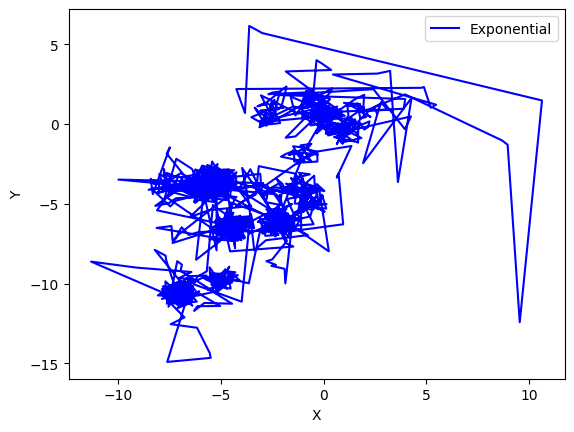

In [88]:
rall = np.stack((xtall,ytall),axis=-1)
rall1 = np.stack((xtall1,ytall1),axis=-1)
print (rall.shape)
print (xtall.shape)
print (rall[:,99,:].shape)
k = 145
plt.plot(xtall[:,k],ytall[:,k], color='blue', label="Exponential")
#plt.plot(xtall1[:,k],ytall1[:,k], color='red', label="Uniform")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

In [89]:
msd = np.zeros(xtall.shape,dtype='float64') #initialise an array for MSD
msd1 = np.zeros(xtall1.shape,dtype='float64') #initialise an array for MSD
print (msd.shape)
for i in range(0,xtall.shape[1]):
#     print i, np.sum(msd[:,i])
    msd[:,i] = calc_msd(rall[:,i,:])
    msd1[:,i] = calc_msd(rall1[:,i,:])

(10000, 1000)


(10000,)
(10000,)


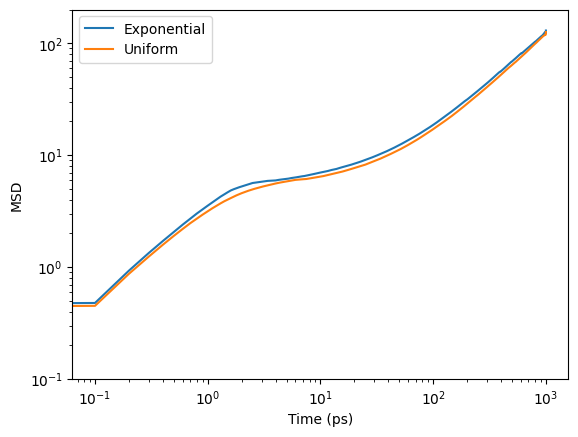

In [90]:
# plt.style.use('seaborn-notebook')
msd_avg = np.average(msd,axis=1)
msd1_avg = np.average(msd1,axis=1)
print (msd_avg.shape)
print( msd_avg.shape)
# print msd_avg
plt.plot(tim,msd_avg, label="Exponential")
plt.plot(tim,msd1_avg, label="Uniform")
plt.xscale("log")
plt.yscale("log")
plt.ylim(0.1,200)
# plt.savefig("test.png",bbox_inches='tight',dpi=300)
plt.xlabel("Time (ps)")
plt.ylabel("MSD")
plt.legend()
plt.show()

In [91]:
def alpha(t, msd):
  return np.gradient(np.log(msd))/np.gradient(np.log(t))

/tmp/ipython-input-91-3536212005.py:2: RuntimeWarning: divide by zero encountered in log
  return np.gradient(np.log(msd))/np.gradient(np.log(t))


Text(0, 0.5, 'Alpha')

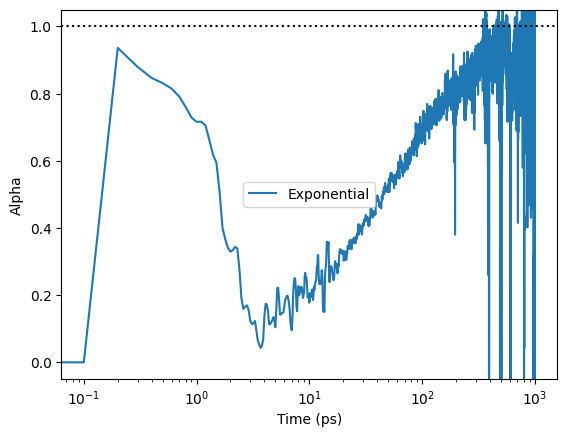

In [92]:
alpha_avg = alpha(tim,msd_avg)
alpha_avg1 = alpha(tim,msd1_avg)
plt.plot(tim,alpha_avg, label="Exponential")
#plt.plot(tim,alpha_avg1, label="Uniform")
plt.ylim(-0.05,1.05)
plt.axhline(1.0, ls=":", color="black")
plt.xscale("log")
plt.legend()
plt.xlabel("Time (ps)")
plt.ylabel("Alpha")